# Cmorization

The `pyremo` package includes a cmorization module that should be useful to rewrite remo output for publication. The module is using the official climate model output rewriter ([CMOR3 API](https://github.com/PCMDI/cmor)) provided by [PCMDI](https://pcmdi.llnl.gov/). The goal of the cmorization process is to provide climate model data output based on the Climate and Forecast (CF) standards to make it easily comparable to other model output.

The model output data not neccessarily altered (except maybe for converting units) but it is rather
organized in a certain manner. For example, the hourly output of remo might be resampled to 3-hourly and daily instantaneous and mean values. Also the variables names and attributes are harmonized to provide standard names and units. Additionally, the different output variables are stored in a certain directory tree that is required for uploading it to an ESGF node.

## Examples
We will show some simple examples here of how the `pyremo` cmorization module can be used. Let's load an example remo dataset that contains monthly means for the year 2000

In [1]:
import xarray as xr
import pyremo as pr

ds = pr.tutorial.open_dataset("remo_EUR-11_TEMP2_mon")
ds

<xarray.Dataset>
Dimensions:                     (rlon: 433, rlat: 433, height2m: 1, time: 12)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * height2m                    (height2m) float64 2.0
    lon                         (rlat, rlon) float64 ...
    lat                         (rlat, rlon) float64 ...
  * time                        (time) datetime64[ns] 2000-01-15 ... 2000-12-15
Data variables:
    TEMP2                       (time, height2m, rlat, rlon) float32 ...
    rotated_latitude_longitude  |S1 ...

The dataset is slightly larger than the official CORDEX domain according to archive specifications. Also the variable name is not CF standard and global attributes are missing. To cmorize this dataset, we use the pyremo cmor module. We also use CMIP6 cmor tables that are provided by `py-cordex`.

In [2]:
from pyremo.cmor import cmorize_variable
from cordex.tables import cordex_cmor_table, cmip6_cmor_table

In [3]:
filename = cmorize_variable(
        ds,
        "tas",
        cmor_table=cmip6_cmor_table("CMIP6_Amon"),
        dataset_table=cordex_cmor_table("CORDEX_remo_example"),
        CORDEX_domain="EUR-11",
    )

/Users/buntemey/python/packages/pyremo/pyremo/cmor/remo_cmor.py:292: UserWarning: time units are set to default: days since 1949-12-01T00:00:00
  warn("time units are set to default: {}".format(u))
/Users/buntemey/python/packages/pyremo/pyremo/cmor/remo_cmor.py:456: UserWarning: adding time bounds
  warn('adding time bounds')

C Traceback:
In function: cmor_grid
! 

!!!!!!!!!!!!!!!!!!!!!!!!!
!
! Warning: it is recommended you pass the latitude bounds values when defining a grid
!
!!!!!!!!!!!!!!!!!!!!!!!!!


C Traceback:
In function: cmor_grid
! 

!!!!!!!!!!!!!!!!!!!!!!!!!
!
! Warning: it is recommended you pass the longitude bounds values when defining a grid
!
!!!!!!!!!!!!!!!!!!!!!!!!!


C Traceback:
In function: cmor_write_var_to_file
! called from: cmor_create_var_attributes
! 

!!!!!!!!!!!!!!!!!!!!!!!!!
!
! Warning: Invalid value(s) detected for variable 'longitude' (table: grids): 62223 values were lower than minimum valid value (0). Minimum encountered bad value (-44.594) was at 

The warnings generated here mostly originate from the fact, that the original CMIP6 cmor tables have not yet been updated for use in regional climate model data. We will ignore them for now and have a look at the output

In [4]:
filename

'CORDEX/CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/historical/r1i1p1f1/Amon/tas/gn/v20220412/tas_Amon_REMO2-0-0_ECMWF-IFS-LR_historical_r1i1p1f1_gn_200001-200012.nc'

In [5]:
output = xr.open_dataset(filename)
output

<xarray.Dataset>
Dimensions:                     (time: 12, bnds: 2, rlat: 412, rlon: 424)
Coordinates:
  * time                        (time) datetime64[ns] 2000-01-15 ... 2000-12-15
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.83
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.15
    latitude                    (rlat, rlon) float64 ...
    longitude                   (rlat, rlon) float64 ...
    height                      float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] ...
    rotated_latitude_longitude  int32 ...
    tas                         (time, rlat, rlon) float32 ...
Attributes: (12/53)
    CORDEX_domain:           EUR-11
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CORDEX
    branch_method:           standard
    branch_time_in_child:    59400.0
    branch_time_in_parent:   59400.0
    ...                      ...
    title:                   REMO2-0-0 output prepared for CMIP6
    tracking_id:             hdl:21.14100/455305d7-69b8-47a5-b76d-329558ca2117
    variable_id:             tas
    variant_label:           r1i1p1f1
    license:                 CMIP6 model data produced by Lawrence Livermore ...
    cmor_version:            3.6.1

You can see that the dataset now has the right dimension sizes and names, added time bounds (since the dataset contains mean values) and also lots of global attributes to self describe the dataset.

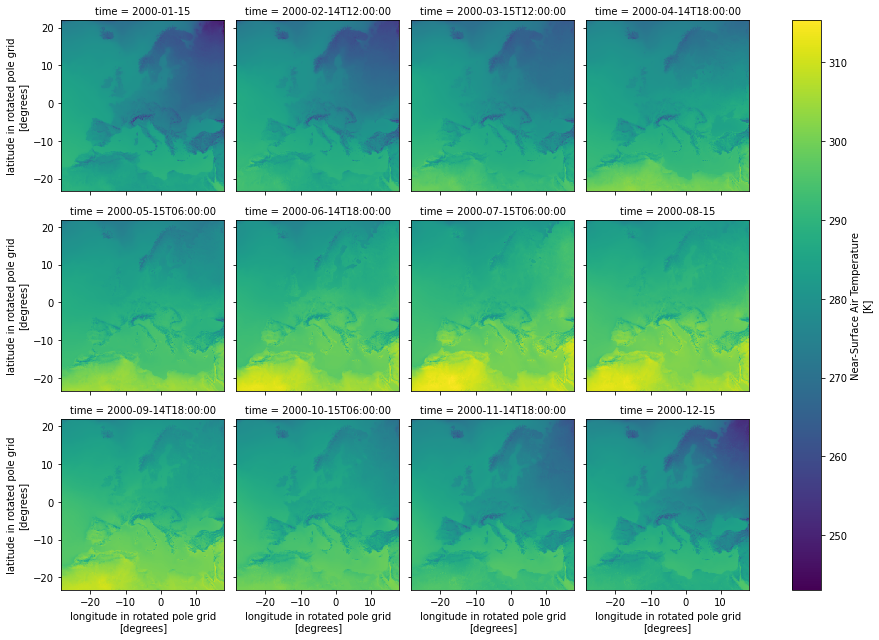

In [6]:
output.tas.plot(col='time', col_wrap=4)